In [3]:
!pip install emoji

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 240.9/240.9 kB 4.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for emoji: filename=emoji-2.2.0-py3-none-any.whl size=234926 sha256=18d4446f4a859d5d3f0238bed09923c84d703899ea67038af68f80095832c9d6
  Stored in directory: /root/.cache/pip/wheels/9a/b8/0f/f580817231cbf59f6ade9fd132ff60ada1de9f7dc85521f857
Successfully built emoji


In [ ]:
!pip install h5py

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [4]:
import pandas as pd
import numpy as np
from keras.utils import to_categorical
from keras import models
from keras import layers
from keras.models import Sequential
from keras.optimizers import RMSprop,Adam
import tensorflow as tf
from sklearn.model_selection import train_test_split
from keras import regularizers
from keras import backend as K
from keras.callbacks import ModelCheckpoint
import keras
import matplotlib.pyplot as plt
import re
import emoji
import pandas as pd
from itertools import groupby
from nltk.corpus import stopwords
import os
from keras.preprocessing.text import Tokenizer
from keras.utils import pad_sequences

In [6]:
"""
Twitch tokenizer. As a code basis the NLTK TwitterTokenizer and the NLTK mark_negation()-method were used.
The basic logic is this:

1. Replace instances of type url, numbers, usernames, chatbot commands, mails with tags.

2. Tokenize text considering e.g. words, various emoticons and twitch emotes.

3. Lowercase tokens except of emoticons and tags.

4. Shortening: normalizing of words with chacters occuring more than twice in succession e.g. "looooove" -> "loove"

5. "_NEG"-Tagging for negated words (see "mark_negation()" impl. for details)

6. Remove all non-alphabetical characters, keep line emoticons, unicode-emoji & emotes

"""

#pattern to match emoticons.
EMOTICONS = r"""
    (?:
      [<>3Oo0|]?
      [:;=8Xx%]                     # eyes
      [']?                        # optional tear
      [\-o\*\']?                 # optional nose
      [\)\]\(\[dDpP/\:\}\{@\|\\X><c3$LSÞ] # mouth
      |
      [\)\]\(\[dDpP/\:\}\{@\|\\X><c3$LSÞ] # mouth
      [\-o\*\']?                 # optional nose
      [']?                        # optional tear
      [:;=8Xx%]                     # eyes
      [<>Oo0|]?
      |<3|<\/3|<\\3
      |
     \( ͡° ͜ʖ ͡°\)                 # lenny face
    |
    ¯\\_\(ツ\)_/¯                  # meh
      |
      >_>|<_<
      |
      @};-|@}->--|@}‑;‑|@>‑‑>‑‑     #rose
      |
      O_O|o\‑o|O_o|o_O|o_o|O\-O     #schock
      |
      >.<|v.v|>>|<<
      |
      \(>_<\)|\^\^|\^_\^|\(-__-\)|\(-_-\)|\(/◕ヮ◕\)/|\(\^o\^\)丿
      |\('_'\)|\(/_;\)|\(T_T\)|\(;_;\)|\(=\^·\^=\)|\(\*_\*\)|\(\+_\+\)|\(@_@\)
      |\(ง •̀_•́\)ง
    )"""

#pattern to match urls.
URL = r"(?:http(s)?:\/\/)?[\w.-]+(?:\.[\w\.-]+)+[\w\-\._~:/?#[\]@!\$&'\(\)\*\+,;=.]+"

# The components of the tokenizer:
REGEXPS = (
    # ASCII Emoticons
    EMOTICONS
    ,
    # HTML tags:
    r"""<[^>\s]+>"""
    ,
    # ASCII Arrows
    r"""[\-]+>|<[\-]+"""
    ,
    # Twitter like hashtags:
    r"""(?:\#+[\w_]+[\w\'_\-]*[\w_]+)"""
    ,
    # Remaining word types:
    r"""
    #(?:[^\W\d_](?:[^\W\d_]|['\-_])+[^\W\d_]) # Words with apostrophes or dashes.
	(?:[^\W_](?:[^\W\d_]|['\-_\d])+[^\W_]) # Words with apostrophes or dashes. (modified)
    |
    (?:[+\-]?\d+[,/.:-]\d+[+\-]?)  # Numbers, including fractions, decimals.
    |
    (?:[\w_]+)                     # Words without apostrophes or dashes.
    |
    (?:\.(?:\s*\.){1,})            # Ellipsis dots.
    |
    (?:\S)                         # Everything else that isn't whitespace.
    """
    )

# Regular expression for negation by Christopher Potts
NEGATION = r"""
    (?:
        ^(?:never|no|nothing|nowhere|noone|none|not|
            havent|hasnt|hadnt|cant|couldnt|shouldnt|
            wont|wouldnt|dont|doesnt|didnt|isnt|arent|aint
        )$
    )
    |
    n't"""

URL_RE = re.compile(URL)
NUM = re.compile("(?<=^|(?<=\s)|(?<=\())#{,1}\d{1,}(?=$|(?=\s)|(?=\)))")
USERNAME = re.compile("(?<=^|(?<=\s))@\w+(?=$|(?=\s))")
COMMAND = re.compile("(?<=^|(?<=\s))!#?[a-zA-Z]+(?=$|(?=\s))")
MAIL = re.compile("[\w.+-]+@[\w-]+\.(?:[\w-]\.?)+[\w-]")

SHORTENING_OF =  re.compile("(.)\\1{2,}")

# pattern to find punctuation
CLAUSE_PUNCT = r'^[.:;!?]$'

# pattern to find non alphabetical chars
NON_ALPHABETICAL = re.compile('[^A-Za-z ]')

# create lexicon of stoppwords
#en_stopwords = set(stopwords.words('english'))
#en_stopwords.add("i'm")
#en_stopwords.add("i've")
#en_stopwords.add("can't")
#stripped_stopwords = [word.replace("'", "") for word in en_stopwords]  # add stopwords without apostrophes
#negated_stopwords = [word+"_NEG" for word in en_stopwords] # add negated stopwords
#[en_stopwords.add(word) for word in stripped_stopwords if word not in en_stopwords]
#[en_stopwords.add(word) for word in negated_stopwords]

# create lexicon of emoji
emoji_lexicon = emoji.EMOJI_DATA

######################################################################
# This is the core tokenizing regex:

WORD_RE = re.compile(r"""(%s)""" % "|".join(REGEXPS), re.VERBOSE | re.I
                     | re.UNICODE)

# WORD_RE performs poorly on these patterns:
HANG_RE = re.compile(r'([^a-zA-Z0-9])\1{3,}')

# The emoticon string gets its own regex so that we can preserve case for
# them as needed:
EMOTICON_RE = re.compile(EMOTICONS, re.VERBOSE | re.I | re.UNICODE)

# These are for regularizing HTML entities to Unicode:
ENT_RE = re.compile(r'&(#?(x?))([^&;\s]+);')

#negation and punctuation matching patterns
NEGATION_RE = re.compile(NEGATION, re.VERBOSE)
CLAUSE_PUNCT_RE = re.compile(CLAUSE_PUNCT)
######################################################################
# Functions for converting html entities
######################################################################

def load_labeled_emotes():
    emotes = set(pd.read_table("/content/drive/MyDrive/textanalytics/Project/emote-controlled/lexica/emote_average.tsv")["word"])
    return emotes

######################################################################

class TwitchTokenizer:

    def __init__(self, preserve_case=True):
        self.preserve_case = preserve_case
        self.emotes = load_labeled_emotes()

    def tokenize(self, text):
        """
        :param text: str
        :rtype: list(str)
        :return: a tokenized list of strings; concatenating this list returns\
        the original string if `preserve_case=False`
        """
        text = URL_RE.sub("URL", text)

        # Shorten problematic sequences of characters
        safe_text = HANG_RE.sub(r'\1\1\1', text)
        # Tokenize:
        words = WORD_RE.findall(safe_text)
        # Possibly alter the case, but avoid changing emoticons like :D into :d:
        if not self.preserve_case:
            words = list(map((lambda x : x if EMOTICON_RE.search(x) else
                              x.lower()), words))
        token_list = []
        for word in words:
            if word not in self.emotes and not re.match(EMOTICON_RE,word):
                if word not in ["URL", "NUM", "USERNAME", "COMMAND","MAIL"]: # do not lowercase tags
                    word = word.lower()
                # shortening: normalizing of words with chacters occuring more than twice in succession e.g. "looooove" -> "loove"
                word = re.sub(SHORTENING_OF, r'\\1\\1', word)
            token_list.append(word)

        # remove all non-alphabetical characters, keep line emoticons, unicode-emoji & emotes
        def keep_token(token):
            if re.match(NON_ALPHABETICAL,token) and not re.match(EMOTICON_RE,token) and token not in self.emotes \
            and token not in emoji_lexicon:
                return False
            else:
                return True

        return token_list

In [7]:
from nltk.tokenize.treebank import TreebankWordDetokenizer
def detokenize(text):
    return TreebankWordDetokenizer().detokenize(text)

cleaning text because out of nowhere the csv is full of semicolumns

In [8]:
def preprocessdataframe(path):
  df = pd.read_csv(path)

  df = df[df['sentiment'] != "sentiment"]
  df = df.reset_index(drop=True)

  df = df[df['comment'] != "comment"]
  df = df.reset_index(drop=True)
  df = df.dropna()
  df.comment = df.comment.str.lower()

  tokenizer = TwitchTokenizer()
  df.comment = df.comment.apply(tokenizer.tokenize)

  df.comment = df.comment.apply(detokenize)

  return df

In [27]:
path = "/content/drive/MyDrive/textanalytics/Project/dataset/labeled_dataset_augmented.csv"
df = preprocessdataframe(path)
#remove this comment to work on the entire dataset
#df = df.sample(frac=0.3, axis=0)
print(len(df))

110810


**Handling sentiment label**

In [28]:
labels = np.array(df['sentiment'])
y = []
for i in range(len(labels)):
    if labels[i] == -1:
        y.append(0)
    if labels[i] == 0:
        y.append(1)
    if labels[i] == 1:
        y.append(2)
    
y = np.array(y)
labels = tf.keras.utils.to_categorical(labels, 3, dtype="float32")
del y
# [neutral, positive, negative]

**Vectorizing the dataset**

In [29]:
df = df.comment.to_numpy()
max_words = 5000
max_len = 100

tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(df)
sequences = tokenizer.texts_to_sequences(df)
comments = pad_sequences(sequences, maxlen=max_len)

**Create the embedding layer**

In [30]:
from keras.layers import Embedding
embedding_layer = Embedding(1000, 64)

**Splitting the dataset into train and test**

In [31]:
X_train, X_test, y_train, y_test = train_test_split(comments,labels, random_state=0)
print (len(X_train),len(X_test),len(y_train),len(y_test))

83107 27703 83107 27703


**Model 1 - LSTM**

In [32]:
model1 = Sequential()
model1.add(layers.Embedding(max_words, 20))
model1.add(layers.LSTM(15,dropout=0.5))
model1.add(layers.Dense(3,activation='softmax'))

model1.compile(optimizer='adam',loss='categorical_crossentropy', metrics=['accuracy'])
#Implementing model checkpoins to save the best metric and do not lose it on training.
checkpoint1 = ModelCheckpoint("best_model1_verAdam_tenepoch_2.hdf5", monitor='val_accuracy', verbose=1,save_best_only=True, mode='auto',save_weights_only=False)
history = model1.fit(X_train, y_train, epochs=10,validation_data=(X_test, y_test),callbacks=[checkpoint1])

Epoch 1/10
2597/2598 [============================>.] - ETA: 0s - loss: 0.3564 - accuracy: 0.8779
Epoch 1: val_accuracy improved from -inf to 0.92633, saving model to best_model1_verAdam_tenepoch_2.hdf5
2598/2598 [==============================] - 177s 67ms/step - loss: 0.3564 - accuracy: 0.8779 - val_loss: 0.2301 - val_accuracy: 0.9263
Epoch 2/10
2597/2598 [============================>.] - ETA: 0s - loss: 0.2148 - accuracy: 0.9338
Epoch 2: val_accuracy improved from 0.92633 to 0.94062, saving model to best_model1_verAdam_tenepoch_2.hdf5
2598/2598 [==============================] - 162s 62ms/step - loss: 0.2148 - accuracy: 0.9338 - val_loss: 0.2004 - val_accuracy: 0.9406
Epoch 3/10
2598/2598 [==============================] - ETA: 0s - loss: 0.1956 - accuracy: 0.9399
Epoch 3: val_accuracy improved from 0.94062 to 0.94192, saving model to best_model1_verAdam_tenepoch_2.hdf5
2598/2598 [==============================] - 154s 59ms/step - loss: 0.1956 - accuracy: 0.9399 - val_loss: 0.1906 

**Model 2 - BiLSTM**

In [37]:
model2 = Sequential()
model2.add(layers.Embedding(max_words, 40, input_length=max_len))
model2.add(layers.Bidirectional(layers.LSTM(20,dropout=0.6)))
model2.add(layers.Dense(3,activation='softmax'))
model2.compile(optimizer='adam',loss='categorical_crossentropy', metrics=['accuracy'])
#Implementing model checkpoins to save the best metric and do not lose it on training.
checkpoint2 = ModelCheckpoint("best_model2_verAdam_tenepoch_2.hdf5", monitor='val_accuracy', verbose=1,save_best_only=True, mode='auto',save_weights_only=False)
history = model2.fit(X_train, y_train, epochs=5,validation_data=(X_test, y_test),callbacks=[checkpoint2])

Epoch 1/5
2598/2598 [==============================] - ETA: 0s - loss: 0.3286 - accuracy: 0.8911
Epoch 1: val_accuracy improved from -inf to 0.93618, saving model to best_model2_verAdam_tenepoch_2.hdf5
2598/2598 [==============================] - 280s 106ms/step - loss: 0.3286 - accuracy: 0.8911 - val_loss: 0.2133 - val_accuracy: 0.9362
Epoch 2/5
2598/2598 [==============================] - ETA: 0s - loss: 0.2080 - accuracy: 0.9351
Epoch 2: val_accuracy improved from 0.93618 to 0.94232, saving model to best_model2_verAdam_tenepoch_2.hdf5
2598/2598 [==============================] - 278s 107ms/step - loss: 0.2080 - accuracy: 0.9351 - val_loss: 0.1890 - val_accuracy: 0.9423
Epoch 3/5
2598/2598 [==============================] - ETA: 0s - loss: 0.1826 - accuracy: 0.9436
Epoch 3: val_accuracy improved from 0.94232 to 0.94618, saving model to best_model2_verAdam_tenepoch_2.hdf5
2598/2598 [==============================] - 278s 107ms/step - loss: 0.1826 - accuracy: 0.9436 - val_loss: 0.1826 

866/866 - 16s - loss: 0.1736 - accuracy: 0.9485 - 16s/epoch - 19ms/step
Model accuracy:  0.9484532475471497
866/866 [==============================] - 18s 20ms/step


<ipython-input-38-9fd87527aff6>:10: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  conf_matrix = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]


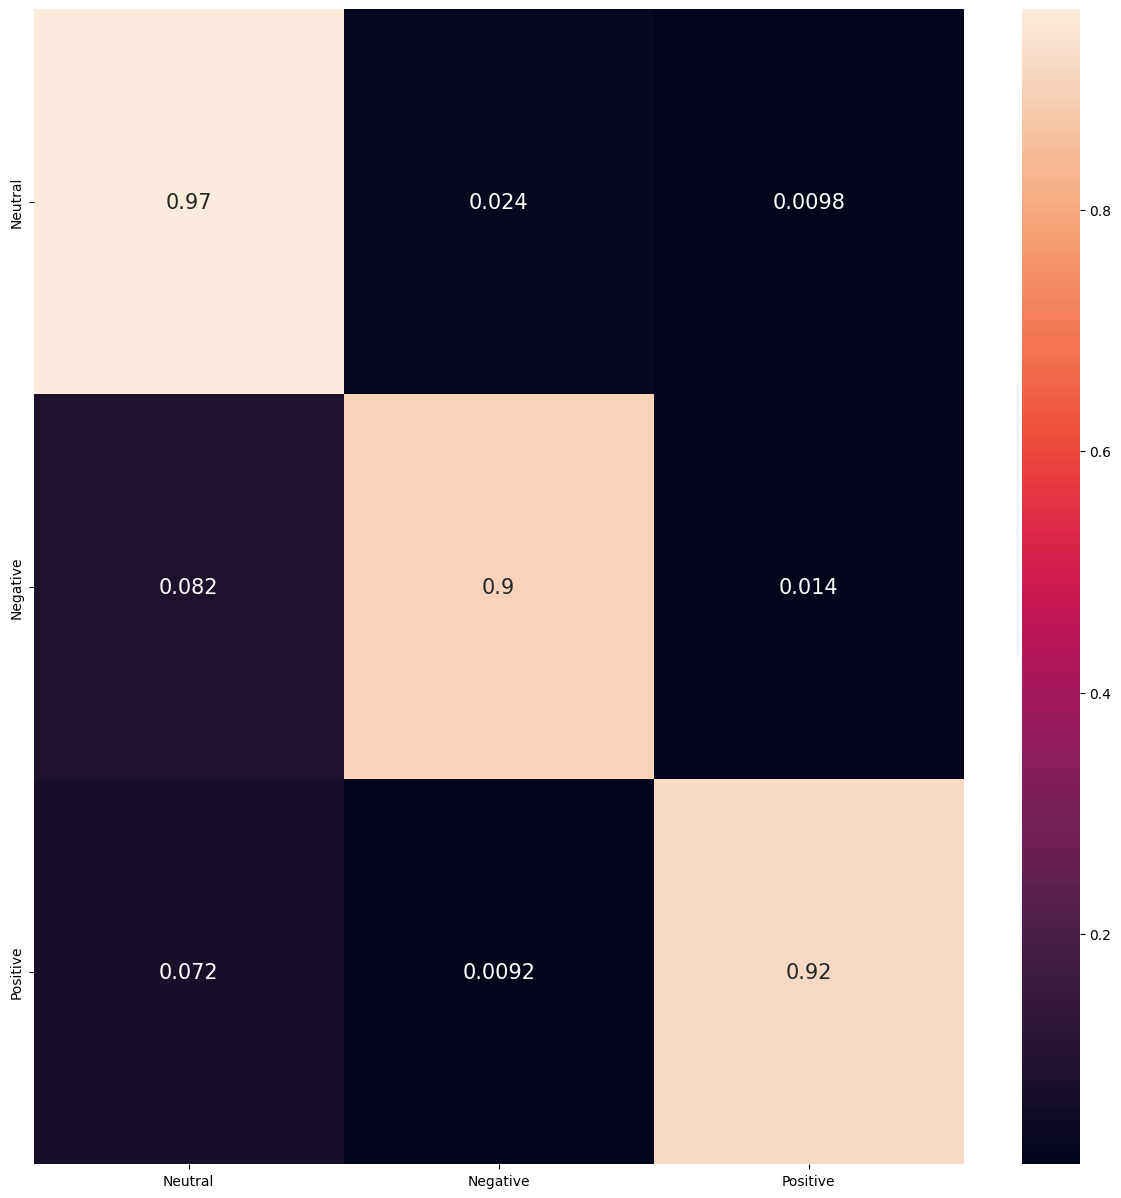

In [38]:
best_model = keras.models.load_model("/content/drive/MyDrive/textanalytics/Project/best_model2_verAdam_tenepoch_2.hdf5")
test_loss, test_acc = best_model.evaluate(X_test, y_test, verbose=2)
print('Model accuracy: ',test_acc)
predictions = best_model.predict(X_test)
from sklearn.metrics import confusion_matrix
matrix = confusion_matrix(y_test.argmax(axis=1), np.around(predictions, decimals=0).argmax(axis=1))
import seaborn as sns
conf_matrix = pd.DataFrame(matrix, index = ['Neutral','Negative','Positive'],columns = ['Neutral','Negative','Positive'])
#Normalizing
conf_matrix = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]
plt.figure(figsize = (15,15))
img = sns.heatmap(conf_matrix, annot=True, annot_kws={"size": 15})
figure = img.get_figure()

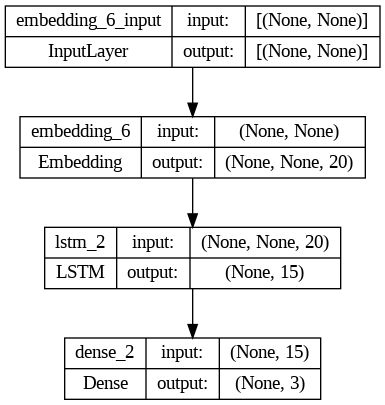

In [18]:
from keras.utils.vis_utils import plot_model
plot_model(best_model, to_file='/content/drive/MyDrive/textanalytics/Project/model_plot_m1.png', show_shapes=True, show_layer_names=True)

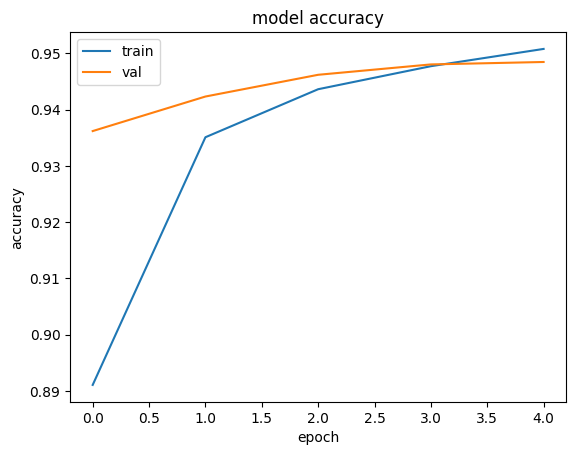

In [39]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.savefig("/content/drive/MyDrive/textanalytics/Project/acc_m2_ten_2.png")
plt.show()

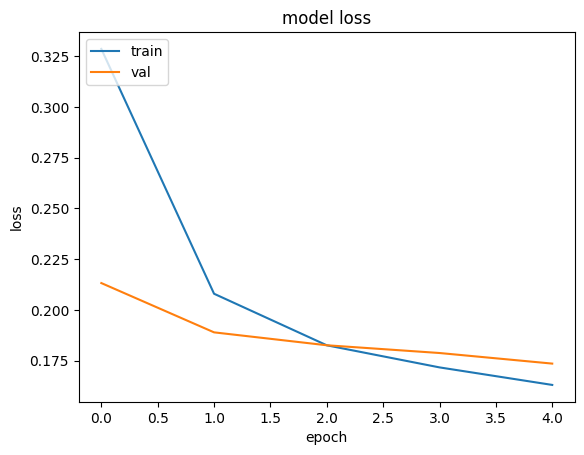

In [40]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.savefig("/content/drive/MyDrive/textanalytics/Project/loss_m2_ten_2.png")
plt.show()

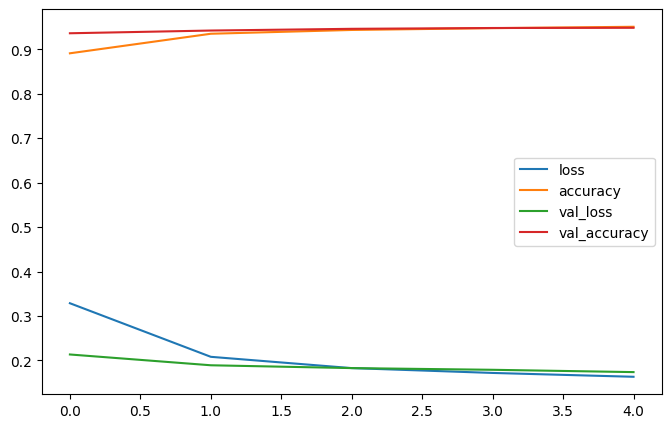

In [41]:
pd.DataFrame(history.history).plot(figsize=(8,5))
plt.savefig("/content/drive/MyDrive/textanalytics/Project/accloss_m2_ten_2.png")
plt.show()

**let's predict the sentiment of a random twitch comment**

In [43]:
sentiment = ["neutral", "positive", "negative"]
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(df)

In [44]:
sequence = tokenizer.texts_to_sequences(['pepehands'])
test = pad_sequences(sequence, maxlen=max_len)
#print(np.around(best_model.predict(test), decimals=0).argmax(axis=1)[0])
sentiment[np.around(best_model.predict(test), decimals=0).argmax(axis=1)[0]]

1/1 [==============================] - 0s 45ms/step


'negative'